# Data Collection and preprocessing

## Setup

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
import sys
from pathlib import Path
import geopandas as gpd

# Add the project root to the Python path to import the modules
project_root = Path().absolute().parent
sys.path.append(str(project_root))

from utils.preprocessing_helpers import convert_layer_to_long_format
from utils.geography_helpers import create_rotated_square_aoi

## Importing building footprints and UNOSAT labels

The script in `scripts/download_footprints_UNOSAT` automates the data collection of:

-  building footprings from [Ballinger (2024)](https://github.com/oballinger/PWTT/tree/main?tab=readme-ov-file)
- building damage labels from [UNOSAT](https://unosat.org/products/4047).  

```console
python scripts/download_footprints_UNOSAT
```
 will fetch the data online and save it to `data/raw`.

## Importing Sentinel-1 data

In [60]:
# Set bounding box for the area of interest (AOI)
create_rotated_square_aoi(
    lat=31.513,
    lon=34.449,
    size_km=4,
    angle_deg=48, 
    filename="../utils/AOI_bboxes/aoi_shifa.geojson"
)

gdf = gpd.read_file("../utils/AOI_bboxes/aoi_shifa.geojson")
print(gdf.geometry[0].wkt)

POLYGON ((34.45033358953366 31.48755359582277, 34.47444640417723 31.51433358953367, 34.44766641046633 31.538446404177233, 34.42355359582277 31.511666410466333, 34.45033358953366 31.48755359582277))


I imported the GeoJSON created above to the [ASF Data Search Vertex](https://search.asf.alaska.edu), and selected the following product:
- Sentinel-1
- GRD-HD
- Polarization: VV+VH
- Orbit: Both Ascending and Descending

For the following dates:

1. Pre-conflict (reference) period (script is `scripts/download-all-2025-04-24_20-32-34`):
- 2023/02/02
- 2023/03/03
- 2023/04/03
- 2023/05/02
- 2023/02/02



## Preprocessing

### Sentinel-1 data

A preprocessing graph was created on the SNAP desktop app with:
- orbit correction
- border and thermal noise removal
- radiometric calibration
- terrain correction

I also manually added a subsetting step using the AOI wkt printed above.

To run it, I invoke:

`/Applications/esa-snap/bin/gpt utils/snap_graphs/s1_preprocessing_graph.xml`

Now we need to extract backscatter values into Numpy arrays.

Shape: (1115, 1114)
CRS: OGC:CRS84
Resolution: 8.983152841195182e-05 m


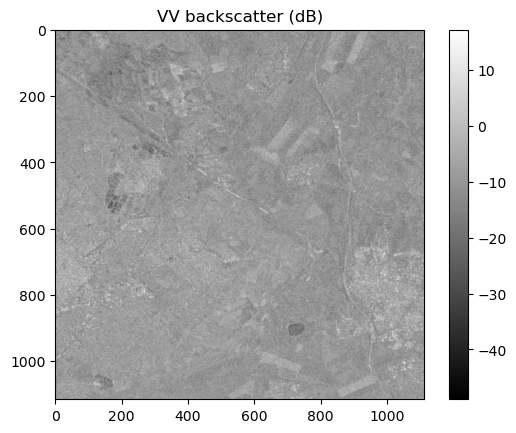

In [ ]:
import rasterio
from rasterio.plot import show
import numpy as np
import matplotlib.pyplot as plt

# VV and VH file paths
vv_path = '../data/preprocessed/sentinel/subset_NorthGaza.data/Sigma0_VV.img'
vh_path = '../data/preprocessed/sentinel/subset_NorthGaza.data/Sigma0_VH.img'

with rasterio.open(vv_path) as src_vv, rasterio.open(vh_path) as src_vh:
    vv = src_vv.read(1)  # Band 1, since the files are single-polarization .img files from SNAP, there is only one band per file.
    vv_dB = 10 * np.log10(vv)
    vh = src_vh.read(1)
    vh_dB = 10 * np.log10(vh)
    profile = src_vv.profile

print("Shape:", vv.shape)
print("CRS:", profile['crs'])
print("Resolution:", profile['transform'][0], "m")

# Show a quick image
plt.imshow(vv_dB, cmap='gray')
plt.title("VV backscatter (dB)")
plt.colorbar()
plt.show()

In [22]:
import geopandas as gpd
from rasterio.mask import mask
import json

# Load your AOI GeoJSON
aoi = gpd.read_file("aoi.geojson")
aoi = aoi.to_crs(profile["crs"])  # Match raster CRS

# Extract geometry for masking
geoms = [json.loads(aoi.to_json())['features'][0]['geometry']]

# Mask VV and VH
with rasterio.open(vv_path) as src:
    vv_masked, _ = mask(src, geoms, crop=True)

with rasterio.open(vh_path) as src:
    vh_masked, _ = mask(src, geoms, crop=True)

### UNOSAT labels

In [16]:
gdb_path = "../data/raw/labels/25_02_2025/UNOSAT_GazaStrip_CDA_25February2025.gdb"
layer_name = "Damage_Sites_GazaStrip_20250225"
# output_path = "../data/raw/labels/gaza_unosat_labels.geojson"

unosat_labels_df = convert_layer_to_long_format(gdb_path, layer_name)

Reading layer: Damage_Sites_GazaStrip_20250225 from ../data/raw/labels/25_02_2025/UNOSAT_GazaStrip_CDA_25February2025.gdb


KeyboardInterrupt: 